# ECO 761: SVAR Estimation



## Set Up
To begin I am loading neccesary libraries and the data. 

In [95]:
import pandas as pd
import numpy as np 
df = pd.read_excel('/Users/chase/Downloads/bpdata.xlsx')

This commands lets me view the data, just to make sure it imported okay.

In [96]:
df.head()

,date,y,t,g,trend,trend2,dum75q2,rrtaxu
0,1950-01-01,-428.265747,-1081.332153,-1117.348755,1,1,0,0.0
1,1950-04-01,-425.807556,-1072.665527,-1116.824219,2,4,0,0.0
2,1950-07-01,-422.493561,-1062.218994,-1121.543823,3,9,0,0.0
3,1950-10-01,-421.014496,-1055.743774,-1112.510742,4,16,0,0.0
4,1951-01-01,-420.063110,-1046.365845,-1094.527344,5,25,0,0.0


Now I am creating a time index for the dataset

In [97]:
df.index = df.date
df.index = pd.to_datetime(df.index)

This function generates lags. Given a number of lags it generates up to $k$ lags where a lag is defined as $$L^{k}Y_t = Y_{t-k}$$

In [105]:
def gen_lags(df, variable, number_of_lags):
    lag = 1
    while lag < number_of_lags + 1:
        df[str(variable) + '-' +str(lag)] = df[str(variable)].shift(lag)
        lag +=1
    return df
        



I loop through the four variables to create the four lag. Then use the .head() method to show it worked. Afterwords I drop the NAs.

In [106]:
variables = ['y', 't', 'g']

for variable in variables:
    gen_lags(df, variable, 4)

In [107]:
df.head()

,date,y,t,g,trend,trend2,dum75q2,rrtaxu,y-1,y-2,y-3,y-4,t-1,t-2,t-3,t-4,g-1,g-2,g-3,g-4
date,,,,,,,,,,,,,,,,,,,,
1951-01-01,1951-01-01,-420.063110,-1046.365845,-1094.527344,5,25,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951-04-01,1951-04-01,-418.762238,-1052.237549,-1079.328613,6,36,0,0.0,-420.063110,NaN,NaN,NaN,-1046.365845,NaN,NaN,NaN,-1094.527344,NaN,NaN,NaN
1951-07-01,1951-07-01,-417.151367,-1054.041504,-1064.522217,7,49,0,0.0,-418.762238,-420.063110,NaN,NaN,-1052.237549,-1046.365845,NaN,NaN,-1079.328613,-1094.527344,NaN,NaN
1951-10-01,1951-10-01,-417.362732,-1049.652954,-1057.280273,8,64,0,0.0,-417.151367,-418.762238,-420.063110,NaN,-1054.041504,-1052.237549,-1046.365845,NaN,-1064.522217,-1079.328613,-1094.527344,NaN
1952-01-01,1952-01-01,-416.799713,-1049.782349,-1055.059326,9,81,0,0.0,-417.362732,-417.151367,-418.762238,-420.06311,-1049.652954,-1054.041504,-1052.237549,-1046.365845,-1057.280273,-1064.522217,-1079.328613,-1094.527344


In [108]:
df = df.dropna(axis = 0)

## Reduced form Estimation via OLS
In the next several lines I estimate the residuals for Y, G, and T. The idea is that "e_variable" is the residuals from 


$$ Y_t = A_1 Y_{t-1} + A_1 Y_{t-1} + \cdots + e_{yt} $$
where $Y_t$ is the vector $[y_t \quad g_t 
\quad t_t]'$

In [109]:
import statsmodels.api as sm # for OLS

X = df[['y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4', 't-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
estimates = {}
for variable in variables:
        estimates[str(variable)] = sm.OLS(df[str(variable)],X).fit()
        df['e_' + str(variable)] =  estimates[str(variable)].resid
  

# Instrument: RES

Now I generate the instrument RES defined in class. Then I run two different 2SLS regressions.  The first regression set is using the residuals, the second is regressing on the lags and showing the results match

In [110]:
df['res'] = df['e_t'] - 2.08* df['e_g']
X = df[['e_g', 'e_t']]
X = sm.add_constant(X)
reg1 = sm.OLS(df['e_y'] ,X).fit()
reg1predict = reg1.fittedvalues
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     39.42
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           2.28e-15
Time:                        17:16:09   Log-Likelihood:                -239.48
No. Observations:                 224   AIC:                             485.0
Df Residuals:                     221   BIC:                             495.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.221e-11      0.047  -2.58e-10      1.000      -0.093       0.093
e_g            0.0696      0.026      2.659      0.008       0.018       0.121
e_t            0.1514      0.018      8.333      0.000       0.116       0.187
==============================================================================
Omnibus:                       13.501   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.016
Skew:                           0.182   Prob(JB):                     1.84e-07
Kurtosis:                       4.786   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
df['res'] = df['e_t'] - 2.08* df['e_y']
X = df[['e_g', 'res']]
X = sm.add_constant(X)
firststage1 = sm.OLS(df['e_t'] ,X).fit()
df['fs1'] = firststage1.fittedvalues
firststage1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_t   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     165.1
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.40e-44
Time:                        17:16:15   Log-Likelihood:                -430.66
No. Observations:                 224   AIC:                             867.3
Df Residuals:                     221   BIC:                             877.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.017e-11      0.111  -9.13e-11      1.000      -0.219       0.219
e_g            0.1544      0.062      2.509      0.013       0.033       0.276
res            0.8729      0.048     18.134      0.000       0.778       0.968
==============================================================================
Omnibus:                       12.686   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.002
Skew:                          -0.147   Prob(JB):                     5.04e-07
Kurtosis:                       4.738   Cond. No.                         2.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
## looks like by the f-stat it is a strong instrument

X = df[['fs1','e_g']]
X = sm.add_constant(X)
secondstage1 = sm.OLS(df['e_y'] ,X).fit()
secondstage1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     7.177
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           0.000955
Time:                        17:16:23   Log-Likelihood:                -266.61
No. Observations:                 224   AIC:                             539.2
Df Residuals:                     221   BIC:                             549.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.599e-12      0.054  -1.05e-10      1.000      -0.105       0.105
fs1           -0.0700      0.027     -2.640      0.009      -0.122      -0.018
e_g            0.0850      0.030      2.877      0.004       0.027       0.143
==============================================================================
Omnibus:                       12.686   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.002
Skew:                          -0.147   Prob(JB):                     5.04e-07
Kurtosis:                       4.738   Cond. No.                         2.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:

X = df[['g','t','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
reg2 = sm.OLS(df['y'],X).fit()
reg2.summary()
## Note how this is the same as the residual regression for the point estimates on t and g. 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.774e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:16:26   Log-Likelihood:                -239.48
No. Observations:                 224   AIC:                             509.0
Df Residuals:                     209   BIC:                             560.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6065     11.175     -0.502      0.616     -27.636      16.423
g              0.0696      0.027      2.586      0.010       0.017       0.123
t              0.1514      0.019      8.104      0.000       0.115       0.188
y-1            1.1308      0.071     15.978      0.000       0.991       1.270
y-2           -0.0733      0.105     -0.700      0.485      -0.280       0.133
y-3           -0.0781      0.104     -0.751      0.454      -0.283       0.127
y-4            0.0295      0.070      0.424      0.672      -0.108       0.167
g-1           -0.1001      0.037     -2.686      0.008      -0.173      -0.027
g-2            0.0537      0.038      1.428      0.155      -0.020       0.128
g-3           -0.0485      0.038     -1.280      0.202      -0.123       0.026
g-4            0.0255      0.024      1.077      0.283      -0.021       0.072
t-1           -0.1133      0.025     -4.539      0.000      -0.162      -0.064
t-2           -0.0544      0.026     -2.094      0.037      -0.106      -0.003
t-3           -0.0252      0.026     -0.975      0.331      -0.076       0.026
t-4            0.0321      0.021      1.544      0.124      -0.009       0.073
==============================================================================
Omnibus:                       13.501   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.016
Skew:                           0.182   Prob(JB):                     1.84e-07
Kurtosis:                       4.786   Cond. No.                     7.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
X = df[['g','res','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
firststage2 = sm.OLS(df['t'] ,X).fit()
df['fs2'] = firststage2.fittedvalues
firststage2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      t   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8184.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):          3.01e-282
Time:                        14:42:59   Log-Likelihood:                -436.52
No. Observations:                 228   AIC:                             903.0
Df Residuals:                     213   BIC:                             954.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -141.7378     24.905     -5.691      0.000    -190.829     -92.646
g              0.1545      0.054      2.868      0.005       0.048       0.261
res            0.8655      0.047     18.481      0.000       0.773       0.958
y-1            1.1065      0.153      7.216      0.000       0.804       1.409
y-2           -0.7281      0.235     -3.097      0.002      -1.192      -0.265
y-3           -0.0781      0.234     -0.334      0.739      -0.540       0.383
y-4           -0.0990      0.159     -0.625      0.533      -0.412       0.214
g-1           -0.3127      0.083     -3.748      0.000      -0.477      -0.148
g-2            0.0123      0.082      0.149      0.881      -0.149       0.174
g-3            0.2441      0.080      3.053      0.003       0.086       0.402
g-4           -0.1277      0.050     -2.576      0.011      -0.225      -0.030
t-1            0.7024      0.047     14.926      0.000       0.610       0.795
t-2            0.2018      0.057      3.533      0.001       0.089       0.314
t-3           -0.1044      0.057     -1.823      0.070      -0.217       0.009
t-4            0.0166      0.047      0.354      0.724      -0.076       0.109
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                     7.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 As shown below, both regessions match! 

In [36]:
X = df[['fs2','g','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
secondstage2 = sm.OLS(df['y'],X).fit()
secondstage2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.166e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:43:00   Log-Likelihood:                -269.54
No. Observations:                 228   AIC:                             569.1
Df Residuals:                     213   BIC:                             620.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.6235     12.592     -2.829      0.005     -60.443     -10.803
fs2           -0.0747      0.026     -2.871      0.005      -0.126      -0.023
g              0.0858      0.026      3.303      0.001       0.035       0.137
y-1            1.3851      0.079     17.526      0.000       1.229       1.541
y-2           -0.2926      0.115     -2.554      0.011      -0.518      -0.067
y-3           -0.0286      0.113     -0.254      0.799      -0.251       0.193
y-4           -0.0111      0.076     -0.146      0.884      -0.161       0.139
g-1           -0.1468      0.041     -3.618      0.000      -0.227      -0.067
g-2            0.0787      0.039      1.995      0.047       0.001       0.156
g-3           -0.0366      0.039     -0.940      0.348      -0.113       0.040
g-4            0.0135      0.024      0.561      0.575      -0.034       0.061
t-1            0.0476      0.029      1.631      0.104      -0.010       0.105
t-2           -0.0016      0.028     -0.059      0.953      -0.057       0.053
t-3           -0.0608      0.028     -2.196      0.029      -0.115      -0.006
t-4            0.0401      0.022      1.784      0.076      -0.004       0.084
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                     7.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## SVAR : Statsmodel

In this section I use the statsmodels precanned SVAR class. This class estimates the SVAR model $$ Ay_t = A_{1}y_{t-1} \cdot + A_{p}y_{t-p} + B$$

To iniatlize this model, you must give the stucture of either the A or B matrix (or both). If only given one, the class default is to use the identity matrix. 'E' denotes unknown parameters which the model will estimate. This class has methods to estiamte impusle response function, do loglikehood estimation, and much more.


 More found [here]( https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.svar_model.SVARResults.html#statsmodels.tsa.vector_ar.svar_model.SVARResults)


In [115]:
## Now I will my results match statsmodel VAR estimation to see if they are similar
import statsmodels.tsa.api as ts
Y = df[['y','g','t']]
Y.index = df.index
A = np.asarray([[1, 0, 0],['E', 1, 0],['E', 'E', 1]])
B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])
model = ts.SVAR(Y,svar_type='AB', A=A, B = B )

/Users/chase/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [78]:
results = model.fit(maxlags = 4,maxiter=100000, maxfun=100000, solver='bfgs')
results.summary()

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 05, Mar, 2020
Time:                     16:30:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.35228
Nobs:                     224.000    HQIC:                   2.99805
Log likelihood:          -1223.45    FPE:                    15.7790
AIC:                      2.75829    Det(Omega_mle):         13.3223
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -31.832350        12.418381           -2.563           0.010
L1.y          1.296238         0.078506           16.511           0.000
L1.g         -0.054748         0.030319           -1.806           0.071
L1.t         -0.000614 

# Impulse Response Function

Below I show the impusle response functions for positive shock in t. (I am not sure why it is producing two graphes currently)

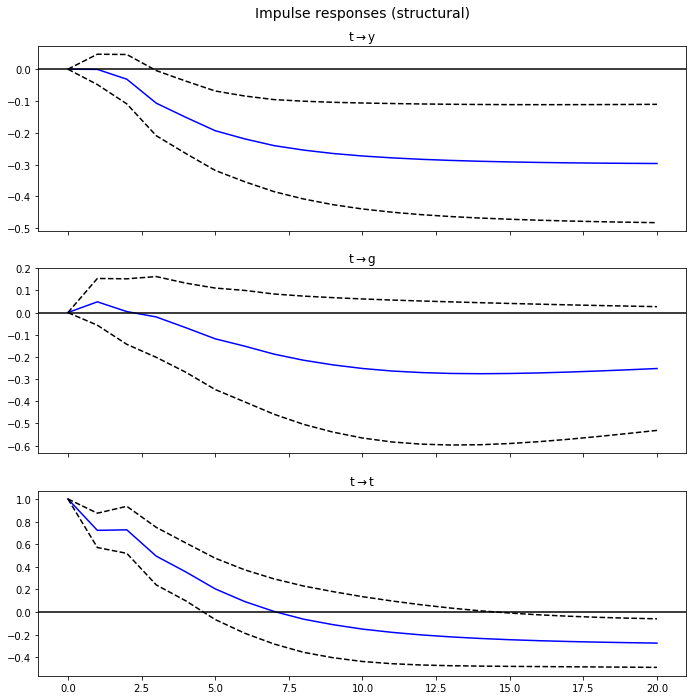

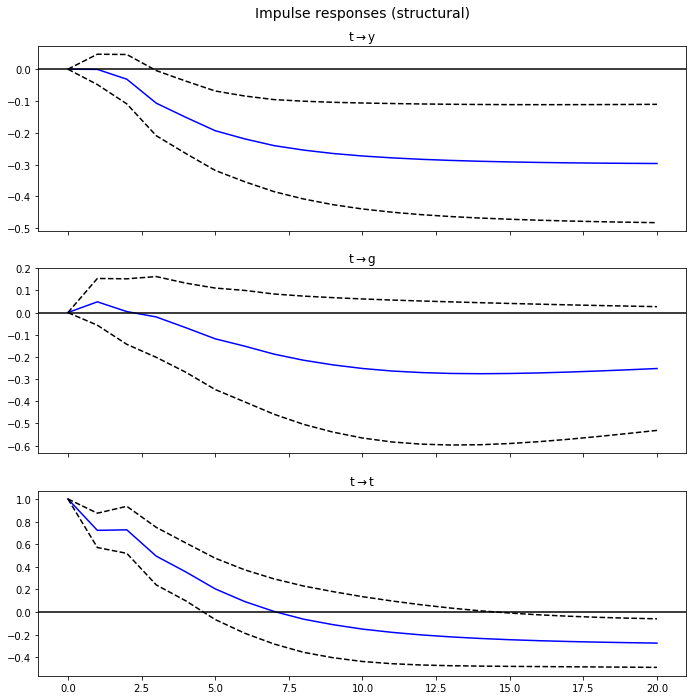

In [81]:
irf = results.irf(20)
irf.plot(impulse = 't')

In the next model, I replace the contemporanous assumption of output and taxes with the the assumption that the coefficent on taxes in 2.08. I need double check if this is the correct way to go about this.

/Users/chase/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


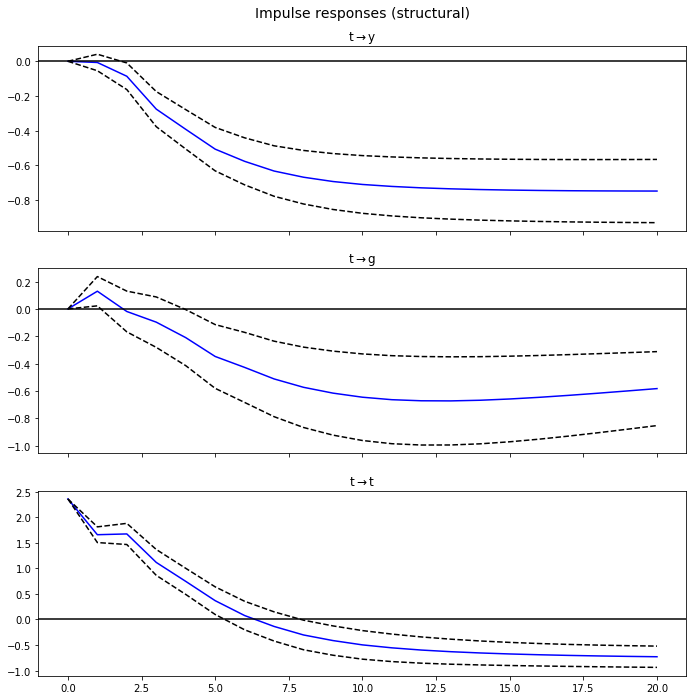

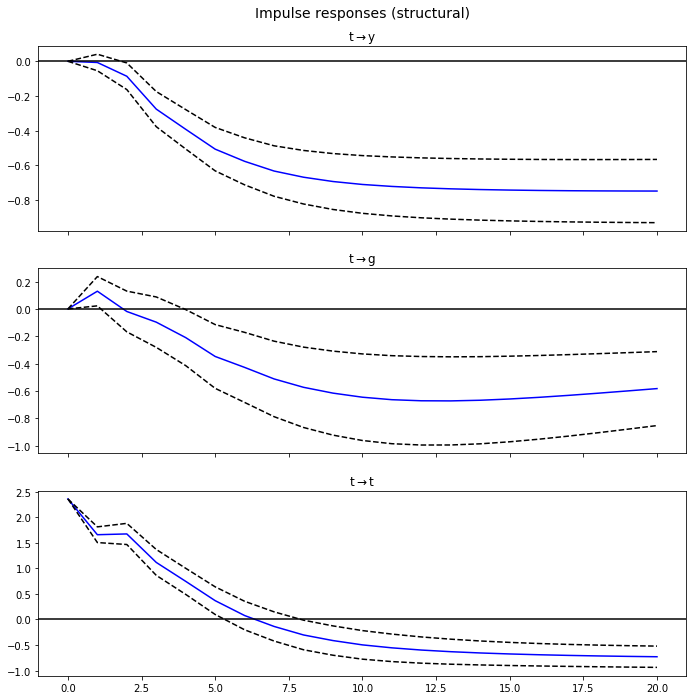

In [116]:
Y = df[['y','g','t']]
Y.index = df.index
# Now changing their relationships 
A = np.asarray([[1, 0, 2.08],['E', 1, 0],['E', 'E', 1]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])
model2 = ts.SVAR(Y,svar_type='A', A=A)
results2 =  model.fit(maxlags = 4,maxiter=100000, maxfun=100000, solver='bfgs')
irf2 = results2.irf(20)
irf2.plot(impulse = 't')

# IRF Part 2:
I want to code up the impulse response functions by hand. I have a few questions before I do this.